# **[Final Exam Chest X-Ray Image로부터 폐렴 검출]**
* Chest X-Ray Images 데이터셋(https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)을 이용해 폐렴 검출하는 모델을 만들고 성능을 검증하세요

*코드 작성 내용 *

1. CNN 모델(2개 이상)을 이용한 정상/폐렴 분류 (Google InceptionV4, Resnet50, AlexNet, U-Net)
2. 분류 결과에 대한 CAM 그리기
3. 각 모델 별 데이터 증강 유/무에 따른 성능 검증
4. CNN 모델 간 성능 비교 검증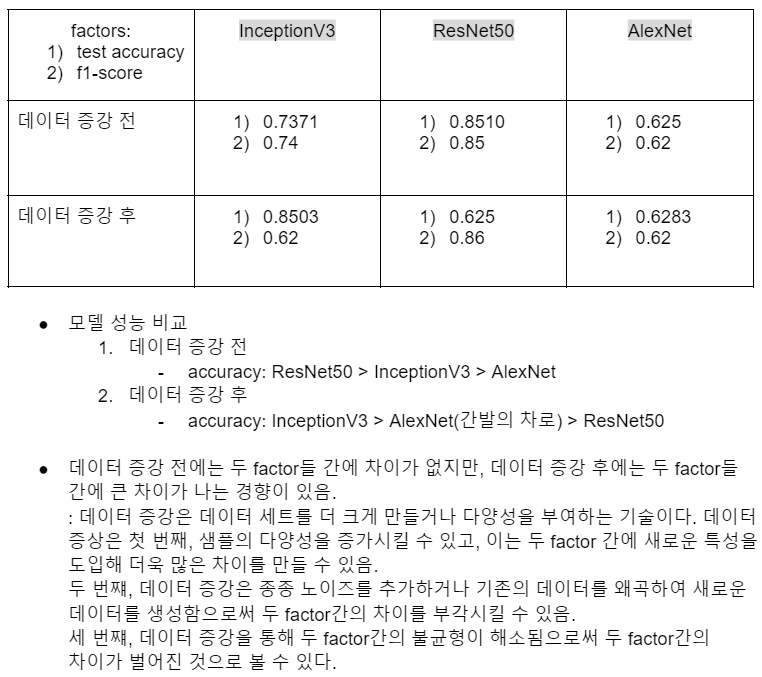

(노트북 메모리 부족으로 kaggle API를 google colab pro로 불러와서 실행)

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"hyozzzzzzzzzzzzzzin","key":"8096629cbcc556693a7735fa9a641c87"}'}

In [2]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
# 다운로드한 데이터셋을 압축 해제
!unzip -o /content/chest-xray-pneumonia.zip -d /content/chest-xray-pneumonia

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: /content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: /content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: /content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: /content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: /content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: /content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: /content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: /content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: /content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: /content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM

In [28]:
# Core
import pandas as pd
import numpy as np
import os
import cv2 #이미지를 읽어와서 표현 etc. 전처리에 필요한 모듈
import gc
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.notebook import tqdm
from datetime import datetime
import json,itertools
from typing import Optional
from glob import glob #image data 처리를 위해 활용되는 모듈
import time
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl
import matplotlib.pyplot as plt
from skimage.transform import resize
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# keras
from tensorflow import keras
import tensorflow as tf
import keras
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Lambda, BatchNormalization, Dropout
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D, Flatten, Dense, Activation
from keras.layers import concatenate
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.models import load_model

# **0. EDA**

In [5]:
#데이터 경로 정의
from pathlib import Path

base_dir = Path("/content/chest-xray-pneumonia/chest_xray")
train_dir = base_dir/"train"
val_dir = base_dir/"val"
test_dir = base_dir/"test"

#데이터 구조 확인: 각 세트의 디렉토리 내용 확인
print(f"Train set directories: {os.listdir(train_dir)}")
print(f"Validation set directories: {os.listdir(val_dir)}")
print(f"Test set directories: {os.listdir(test_dir)}")

Train set directories: ['PNEUMONIA', 'NORMAL']
Validation set directories: ['PNEUMONIA', 'NORMAL']
Test set directories: ['PNEUMONIA', 'NORMAL']


In [6]:
#데이터 샘플 확인
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

train_normal_images = load_images_from_folder(train_dir / "NORMAL")
train_pneumonia_images = load_images_from_folder(train_dir / "PNEUMONIA")

print(f"Number of NORMAL images in train set: {len(train_normal_images)}")
print(f"Number of PNEUMONIA images in train set: {len(train_pneumonia_images)}")

Number of NORMAL images in train set: 1341
Number of PNEUMONIA images in train set: 3875


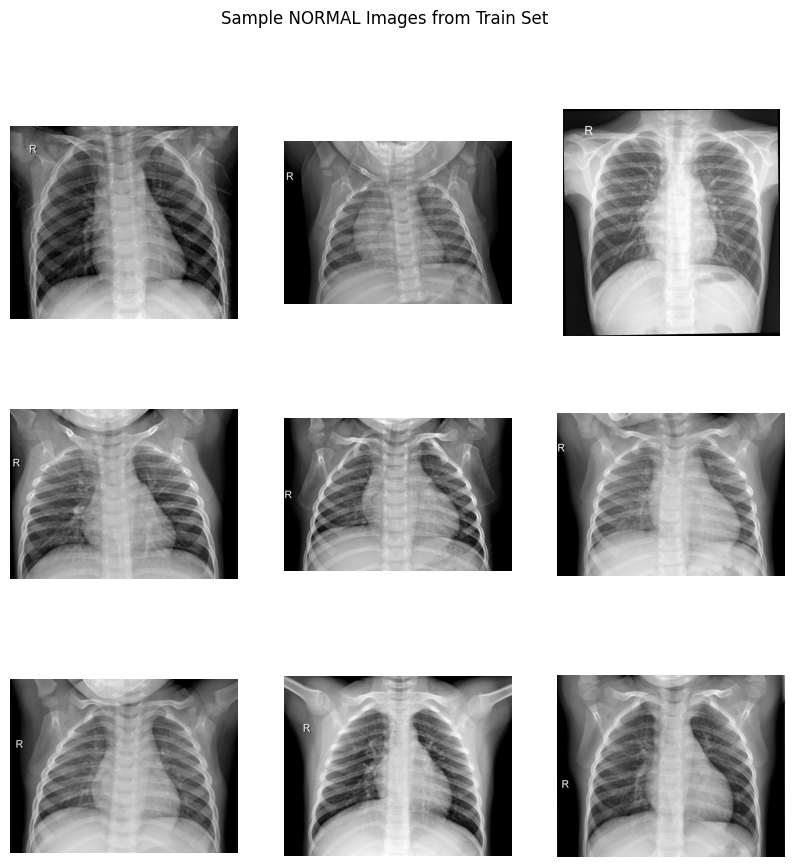

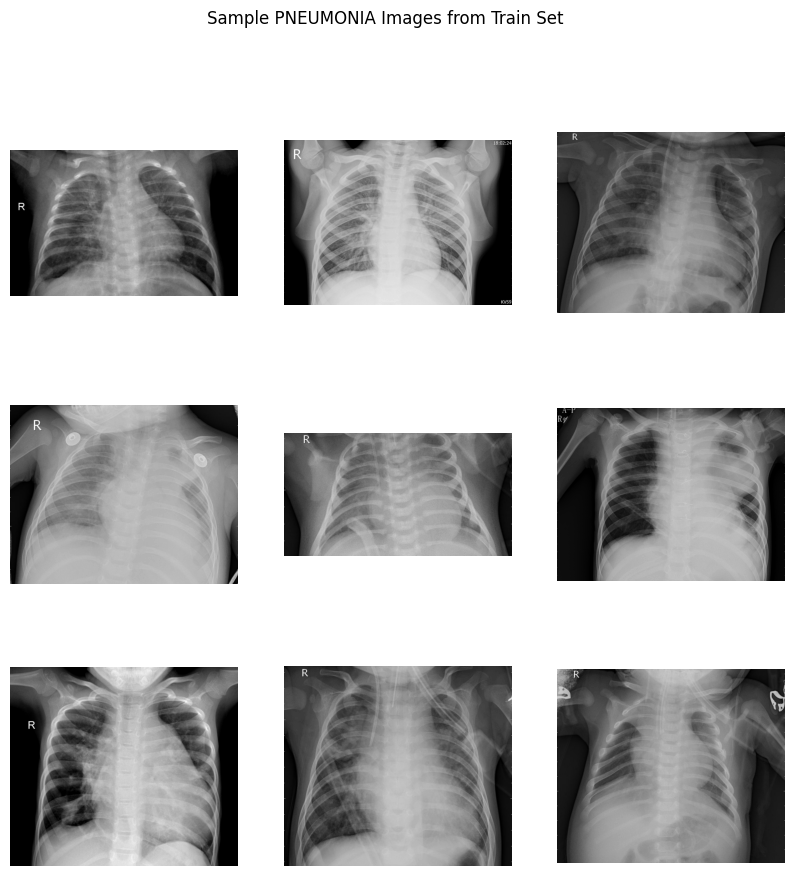

In [7]:
#데이터 시각화
def plot_sample_images(images, title):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

plot_sample_images(train_normal_images, "Sample NORMAL Images from Train Set")
plot_sample_images(train_pneumonia_images, "Sample PNEUMONIA Images from Train Set")

In [8]:
#train, val, test 데이터 통계 분석
def count_images_in_directory(directory):
    normal_count = len(os.listdir(directory / "NORMAL"))
    pneumonia_count = len(os.listdir(directory / "PNEUMONIA"))
    return normal_count, pneumonia_count

train_normal_count, train_pneumonia_count = count_images_in_directory(train_dir)
val_normal_count, val_pneumonia_count = count_images_in_directory(val_dir)
test_normal_count, test_pneumonia_count = count_images_in_directory(test_dir)

print(f"Train set - NORMAL: {train_normal_count}, PNEUMONIA: {train_pneumonia_count}")
print(f"Validation set - NORMAL: {val_normal_count}, PNEUMONIA: {val_pneumonia_count}")
print(f"Test set - NORMAL: {test_normal_count}, PNEUMONIA: {test_pneumonia_count}")

Train set - NORMAL: 1341, PNEUMONIA: 3875
Validation set - NORMAL: 8, PNEUMONIA: 8
Test set - NORMAL: 234, PNEUMONIA: 390


# **0. 데이터 전처리**

In [9]:
#이미지와 라벨 로드 함수 정의
def load_images_and_labels(directory):
    images = []
    labels = []
    for label_type in ["NORMAL", "PNEUMONIA"]:
        label_dir = directory / label_type
        for filename in os.listdir(label_dir):
            img_path = label_dir / filename
            img = Image.open(img_path).convert('L')  # 흑백 이미지로 변환
            img = img.resize((299, 299))  # 크기 조정
            img_array = np.array(img)
            images.append(img_array)
            labels.append(0 if label_type == "NORMAL" else 1)
    return np.array(images), np.array(labels)

train_images, train_labels = load_images_and_labels(train_dir)
val_images, val_labels = load_images_and_labels(val_dir)
test_images, test_labels = load_images_and_labels(test_dir)

In [10]:
#라벨 원-핫 인코딩: 라벨을 원-핫 인코딩으로 변환함
train_labels = to_categorical(train_labels, 2)
val_labels = to_categorical(val_labels, 2)
test_labels = to_categorical(test_labels, 2)

In [11]:
print("Train images shape:", train_images.shape)
print("Validation images shape:", val_images.shape)

Train images shape: (5216, 299, 299)
Validation images shape: (16, 299, 299)


In [12]:
#데이터증강
# 4차원이어야 해서 채널 수를 추가
train_images = np.expand_dims(train_images, axis=-1)
val_images = np.expand_dims(val_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

#데이터 증강 코드
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255,
    fill_mode='nearest'
)

# 검증 및 테스트 데이터에 대한 데이터 생성기 생성
val_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
print("Train images shape after adding channel dimension:", train_images.shape)
print("Validation images shape after adding channel dimension:", val_images.shape)
print("Test images shape after adding channel dimension:", test_images.shape)

Train images shape after adding channel dimension: (5216, 299, 299, 1)
Validation images shape after adding channel dimension: (16, 299, 299, 1)
Test images shape after adding channel dimension: (624, 299, 299, 1)


In [14]:
# 흑백 이미지를 RGB 이미지로 변환 (채널 수를 1에서 3으로 확장)
train_images = np.repeat(train_images, 3, axis=-1)
val_images = np.repeat(val_images, 3, axis=-1)
test_images = np.repeat(test_images, 3, axis=-1)

print("Train images shape after channel expansion:", train_images.shape)
print("Validation images shape after channel expansion:", val_images.shape)
print("Test images shape after channel expansion:", test_images.shape)

Train images shape after channel expansion: (5216, 299, 299, 3)
Validation images shape after channel expansion: (16, 299, 299, 3)
Test images shape after channel expansion: (624, 299, 299, 3)


In [15]:
train_generator = train_datagen.flow(train_images, train_labels, batch_size=16)
val_generator = val_datagen.flow(val_images, val_labels, batch_size=16)

In [16]:
#전처리된 데이터 저장
np.save('train_images.npy', train_images)
np.save('train_labels.npy', train_labels)
np.save('val_images.npy', val_images)
np.save('val_labels.npy', val_labels)
np.save('test_images.npy', test_images)
np.save('test_labels.npy', test_labels)

# **1.  CNN 모델(2개 이상)을 이용한 정상/폐렴 분류**

: Google InceptionV4, Resnet50, AlexNet model 이용

# **+ 2. 분류 결과에 대한 CAM 그리기**
# **+ 3. 각 모델 별 데이터 증강 유/무에 따른 성능 검증**

**각 모델의 목적 및 특징 비교**

1) AlexNet: 주로 이미지 분류(image classification)를 목적으로 설계되었습니다. 특정 카테고리의 이미지가 주어졌을 때, 그 이미지가 어떤 카테고리에 속하는지 예측합니다. 주로 이미지의 전역적인 특징(global features)을 학습하여 전체 이미지를 특정 클래스로 분류합니다.

2) U-Net: 주로 이미지 분할(image segmentation)을 목적으로 설계되었습니다. 이미지 내의 각 픽셀이 어떤 클래스에 속하는지 예측하여, 세부적인 영역 구분이 가능합니다. 이미지의 국소적인 특징(local features)을 학습하여 각 픽셀 단위로 클래스를 예측하고, 정확한 영역 분할을 수행합니다.

3) ResNet: 잔차 블록을 사용하여 매우 깊은 네트워크를 효과적으로 학습. 이미지분류에 사용되며 깊이있는 네트워크 설계에 중점을 둠.

4) Inception: 다양한 크기의 합성곱과 풀링을 병렬로 실행하여 다양한 스케일의 특징을 추출. 이미지 분류에 사용되며 깊이있는 네트워크 설계에 중점을 둠.

**1) first CNN model: Google InceptionV3**

In [17]:
#google InceptionV3 model 생성
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

googlenet = InceptionV3(include_top=False, input_shape=(299, 299, 3), weights='imagenet')

#모델 정의
x = googlenet.output
x = GlobalAveragePooling2D(name='glo_avg_pool')(x)
x = Dense(128, name='fully_128', activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(2, activation='softmax')(x)
model = Model(googlenet.input, outputs=x)
model.summary()

#일부 레이어 고정: 사전훈련 모델은 이미 많은 데이터로 안정화된 가중치를 지님. 이 가중피를 고정하면 새로운 데이터로 학습 시 모델이 기존에 학습된 유용한 특징을 유지할 수 있음
for layer in googlenet.layers:
    layer.trainable = False

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0][0

In [18]:
#모델 컴파일
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

*InceptionV3 CAM 그리기*

In [19]:
print("훈련 세트 이미지 수:", len(train_images))
print("검증 세트 이미지 수:", len(val_images))
print("테스트 세트 이미지 수:", len(test_images))

훈련 세트 이미지 수: 5216
검증 세트 이미지 수: 16
테스트 세트 이미지 수: 624


==> 검증 세트 이미지 수가 16이므로, len(train_images)&len(val_images)를 나누는 배치사이즈의 크기는 최대 16이어야 한다. 16보다 크게 설정할 수 없음. 따라서 배치사이즈 크기를 32 -> 16으로 전반적으로 조정했다.

In [20]:
#앞서 만든 InceptionV3에서 CAM을 찍어보는 코드를 생성
cam_model = Model(inputs=model.input, outputs=(model.layers[-3].output, model.layers[-1].output))
cam_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0]

In [21]:
import scipy
from scipy import ndimage

#CAM을 찍을 수 있는 function 생성
def show_cam(image_value, features, results):

    #there is only one image in the batch so we index at '0'
    features_for_img = features[0] #batch_szie는 32이지만, CAM을 찍을 때는 하나만 찍을 것이므로 첫 번째 feature들에 대해서만 feature map을 가져오면 됨
    prediction = np.argmax(results) #prediction은 최종적으로 나온 output결과로 잡아준다: GAP를 통해 어떤 값을 예측했는지를 찾아버기 위해 'argmax'를 활용해준다

    #there is only one unit in the output so we get the weights connected to it
    gap_weights = model.layers[-1].get_weights()[0] #모델의 제일 마지막단과 + 그 앞단에서 연결되는 weight에 대해 불러옴; batch_size에 대해 다 불러오지 않고 하나만 들어가야 하므로, 첫 번째 값에 대해서 GAP와 output을 연결하는 weight들을 이곳에서 불러오게 됨
    class_activation_weights = gap_weights[:, prediction] #마지막단에서 찍는 것은 class들과 연결된 weight값들만 뽑아와야 함(그러기 위해서 바로 전에 prediction값을 뽑아온 것)
                                        #앞의 weight값들 중, prediction과 연결된 값들만 뽑아준다

    #upsample to the image size
    class_activation_features = scipy.ndimage.zoom(features_for_img, (None, 299/128, 299/128, None), order=2)

    #compute the intensity of each feature in the CAM
    cam_output = np.dot(class_activation_features, class_activation_weights)

    #visulize the results
    plt.figure(figsize=(8,8))
    plt.imshow(cam_output, cmap='jet', alpha=0.5)
    plt.imshow(tf.squeeze(image_value), alpha=0.5)
    plt.show()

In [22]:
import numpy as np
import scipy.ndimage

#CAM을 찍을 수 있는 function 생성
def show_cam(image_value, features, results):

    #there is only one image in the batch so we index at '0'
    features_for_img = features[0] #batch_szie는 32이지만, CAM을 찍을 때는 하나만 찍을 것이므로 첫 번째 feature들에 대해서만 feature map을 가져오면 됨
    prediction = np.argmax(results) #prediction은 최종적으로 나온 output결과로 잡아준다: GAP를 통해 어떤 값을 예측했는지를 찾아버기 위해 'argmax'를 활용해준다

    #there is only one unit in the output so we get the weights connected to it
    gap_weights = model.layers[-1].get_weights()[0] #모델의 제일 마지막단과 + 그 앞단에서 연결되는 weight에 대해 불러옴; batch_size에 대해 다 불러오지 않고 하나만 들어가야 하므로, 첫 번째 값에 대해서 GAP와 output을 연결하는 weight들을 이곳에서 불러오게 됨
    class_activation_weights = gap_weights[:, prediction] #마지막단에서 찍는 것은 class들과 연결된 weight값들만 뽑아와야 함(그러기 위해서 바로 전에 prediction값을 뽑아온 것)
                                        #앞의 weight값들 중, prediction과 연결된 값들만 뽑아준다

    #upsample to the image size
    class_activation_features = np.expand_dims(features_for_img, axis=-1)  # 새로운 축 추가

    #compute the intensity of each feature in the CAM
    cam_output = scipy.ndimage.zoom(class_activation_features, (1, 299/128, 299/128, 3), order=2)
    cam_output = np.squeeze(cam_output, axis=-1)  # 새로운 축 제거
    cam_output = np.dot(cam_output, class_activation_weights)

    #visulize the results
    plt.figure(figsize=(8,8))
    plt.imshow(cam_output, cmap='jet', alpha=0.5)
    plt.imshow(tf.squeeze(image_value), alpha=0.5)
    plt.show()

In [23]:
from PIL import Image

# 이미지 파일 경로
img_path = "/content/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person100_bacteria_482.jpeg"

# 이미지 불러오기
img = Image.open(img_path)

# 이미지 크기 조정 및 채널 추가
img = img.resize((299, 299))
img = np.array(img)
if len(img.shape) == 2:
    img = np.stack((img,) * 3, axis=-1)

# 이미지 전처리
test_img = img.reshape(-1, 299,299, 3)
test_img_proc = test_img / 255.0  # 이미지를 모델에 입력하기 전에 전처리

# CAM 생성에 사용할 이미지 준비 완료

In [26]:
#cam_input = np.expand_dims(test_img_proc, axis=0)
features, results = cam_model.predict(test_img_proc) #preprocessing해준 것들을 CAM model에 들어가는 feature map과 예측결과를 넘겨서 활용해준다

show_cam(test_img, features, results)

1/1 [==============================] - 0s 28ms/step


RuntimeError: sequence argument must have length equal to input rank

*각 모델별 데이터 증강 유/무에 따른 성능 검증*

In [30]:
# 모델 학습1: 증강을 거치지 않은 데이터 학습
model.fit(
    train_images, train_labels,
    epochs=10,
    batch_size=16,
    validation_data=(val_images, val_labels)
)

# 모델 평가
loss, accuracy = model.evaluate(test_images, test_labels)
print(f'Original data Test accuracy: {accuracy}')

# 테스트 데이터 예측
predictions = model.predict(test_images, batch_size=32)
# 예측 결과를 클래스 레이블로 변환
predicted_classes = np.argmax(predictions, axis=1)
# 실제 클래스 레이블
true_classes = np.argmax(test_labels, axis=1)
report = classification_report(true_classes, predicted_classes)
print(f'Original data Classification Report: {report}')

# 모델 저장 (선택사항)
model.save('inceptionv3_chest_xray_Original.h5')

Epoch 1/10
326/326 [==============================] - 5s 15ms/step - loss: 0.2973 - accuracy: 0.8470 - val_loss: 0.9740 - val_accuracy: 0.6250
Epoch 2/10
326/326 [==============================] - 5s 15ms/step - loss: 0.3205 - accuracy: 0.8282 - val_loss: 1.1992 - val_accuracy: 0.6250
Epoch 3/10
326/326 [==============================] - 5s 15ms/step - loss: 0.2932 - accuracy: 0.8520 - val_loss: 1.3203 - val_accuracy: 0.6250
Epoch 4/10
326/326 [==============================] - 5s 15ms/step - loss: 0.2773 - accuracy: 0.8622 - val_loss: 1.1542 - val_accuracy: 0.6250
Epoch 5/10
326/326 [==============================] - 5s 15ms/step - loss: 0.3022 - accuracy: 0.8445 - val_loss: 1.1208 - val_accuracy: 0.6250
Epoch 6/10
326/326 [==============================] - 5s 14ms/step - loss: 0.3105 - accuracy: 0.8368 - val_loss: 1.0907 - val_accuracy: 0.6250
Epoch 7/10
326/326 [==============================] - 5s 15ms/step - loss: 0.2869 - accuracy: 0.8610 - val_loss: 0.6790 - val_accuracy: 0.8750

In [31]:
#모델 학습2: 증강을 거친 데이터 학습
model.fit(
    train_generator,
    steps_per_epoch=len(train_images) // 16,
    validation_data=val_generator,
    validation_steps=len(val_images) // 16,
    epochs=10
)

# 모델 평가
test_generator = val_datagen.flow(test_images, test_labels, batch_size=32)
# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_generator, steps=len(test_images) // 32)
print(f'Generation data Test accuracy: {accuracy}')

# 테스트 데이터 예측
predictions = model.predict(test_images, batch_size=32)
# 예측 결과를 클래스 레이블로 변환
predicted_classes = np.argmax(predictions, axis=1)
# 실제 클래스 레이블
true_classes = np.argmax(test_labels, axis=1)
report = classification_report(true_classes, predicted_classes)
print(f'Original data Classification Report: {report}')

# 모델 저장
model.save('inceptionv4_chest_xray_Generation.h5')

Epoch 1/10
326/326 [==============================] - 95s 283ms/step - loss: 0.3384 - accuracy: 0.8489 - val_loss: 0.4079 - val_accuracy: 0.8750
Epoch 2/10
326/326 [==============================] - 90s 277ms/step - loss: 0.2738 - accuracy: 0.8913 - val_loss: 0.4209 - val_accuracy: 0.8750
Epoch 3/10
326/326 [==============================] - 91s 278ms/step - loss: 0.2664 - accuracy: 0.8896 - val_loss: 0.4163 - val_accuracy: 0.8750
Epoch 4/10
326/326 [==============================] - 90s 276ms/step - loss: 0.2384 - accuracy: 0.9109 - val_loss: 0.4031 - val_accuracy: 0.8750
Epoch 5/10
326/326 [==============================] - 91s 280ms/step - loss: 0.2203 - accuracy: 0.9174 - val_loss: 0.3379 - val_accuracy: 0.8125
Epoch 6/10
326/326 [==============================] - 90s 277ms/step - loss: 0.2240 - accuracy: 0.9199 - val_loss: 0.4766 - val_accuracy: 0.7500
Epoch 7/10
326/326 [==============================] - 90s 277ms/step - loss: 0.2193 - accuracy: 0.9179 - val_loss: 0.3563 - val_ac

**2) ResNet50**

In [32]:
from tensorflow.keras.applications import ResNet50

res50 = ResNet50(include_top=False, input_shape=(299, 299, 3), weights='imagenet')

x = res50.output
x = GlobalAveragePooling2D(name='glo_avg_pool')(x)
x = Dense(128, name='fully_128', activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(2, activation='softmax', name='fc_final')(x)
model = Model(res50.input, outputs=x)
model.summary()

#일부 레이어 고정
for layer in res50.layers:
    layer.trainable = False

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 305, 305, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 150, 150, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 150, 150, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [33]:
#모델 컴파일
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

*('분류 결과에 대한 CAM 그리기' 코드는 6시간 동안 시도해보았으나, 오류가 해결되지 않아 우선 생략)*

*각 모델별 데이터 증강 유/무에 따른 성능 검증*

In [34]:
# 모델 학습1: 증강을 거치지 않은 데이터 학습
model.fit(
    train_images, train_labels,
    epochs=10,
    batch_size=16,
    validation_data=(val_images, val_labels)
)

# 모델 평가
loss, accuracy = model.evaluate(test_images, test_labels)
print(f'Original data Test accuracy: {accuracy}')

# 테스트 데이터 예측
predictions = model.predict(test_images, batch_size=32)
# 예측 결과를 클래스 레이블로 변환
predicted_classes = np.argmax(predictions, axis=1)
# 실제 클래스 레이블
true_classes = np.argmax(test_labels, axis=1)
report = classification_report(true_classes, predicted_classes)
print(f'Original data Classification Report: {report}')

# 모델 저장 (선택사항)
model.save('ResNet50_chest_xray_Original.h5')

Epoch 1/10
326/326 [==============================] - 11s 22ms/step - loss: 0.1796 - accuracy: 0.9308 - val_loss: 0.4796 - val_accuracy: 0.8125
Epoch 2/10
326/326 [==============================] - 6s 19ms/step - loss: 0.1209 - accuracy: 0.9549 - val_loss: 0.1747 - val_accuracy: 0.9375
Epoch 3/10
326/326 [==============================] - 6s 19ms/step - loss: 0.1021 - accuracy: 0.9609 - val_loss: 0.7022 - val_accuracy: 0.6875
Epoch 4/10
326/326 [==============================] - 6s 19ms/step - loss: 0.0984 - accuracy: 0.9636 - val_loss: 0.1566 - val_accuracy: 0.9375
Epoch 5/10
326/326 [==============================] - 6s 19ms/step - loss: 0.0858 - accuracy: 0.9680 - val_loss: 0.0847 - val_accuracy: 1.0000
Epoch 6/10
326/326 [==============================] - 6s 19ms/step - loss: 0.0762 - accuracy: 0.9678 - val_loss: 0.0619 - val_accuracy: 1.0000
Epoch 7/10
326/326 [==============================] - 6s 19ms/step - loss: 0.0878 - accuracy: 0.9684 - val_loss: 0.7564 - val_accuracy: 0.687

In [35]:
#모델 학습2: 증강을 거친 데이터 학습
model.fit(
    train_generator,
    steps_per_epoch=len(train_images) // 16,
    validation_data=val_generator,
    validation_steps=len(val_images) // 16,
    epochs=10
)

# 모델 평가
test_generator = val_datagen.flow(test_images, test_labels, batch_size=16)
loss, accuracy = model.evaluate(test_generator, steps=len(test_images) // 16)
print(f'Generation data Test accuracy: {accuracy}')

# 테스트 데이터 예측
predictions = model.predict(test_images, batch_size=32)
# 예측 결과를 클래스 레이블로 변환
predicted_classes = np.argmax(predictions, axis=1)
# 실제 클래스 레이블
true_classes = np.argmax(test_labels, axis=1)
report = classification_report(true_classes, predicted_classes)
print(f'Original data Classification Report: {report}')

# 모델 저장
model.save('ResNet50_chest_xray_Generation.h5')

Epoch 1/10
326/326 [==============================] - 93s 281ms/step - loss: 0.6217 - accuracy: 0.7327 - val_loss: 0.7757 - val_accuracy: 0.5000
Epoch 2/10
326/326 [==============================] - 92s 281ms/step - loss: 0.5795 - accuracy: 0.7429 - val_loss: 0.7800 - val_accuracy: 0.5000
Epoch 3/10
326/326 [==============================] - 92s 283ms/step - loss: 0.5752 - accuracy: 0.7429 - val_loss: 0.7712 - val_accuracy: 0.5000
Epoch 4/10
326/326 [==============================] - 92s 281ms/step - loss: 0.5730 - accuracy: 0.7429 - val_loss: 0.8300 - val_accuracy: 0.5000
Epoch 5/10
326/326 [==============================] - 90s 276ms/step - loss: 0.5705 - accuracy: 0.7429 - val_loss: 0.8055 - val_accuracy: 0.5000
Epoch 6/10
326/326 [==============================] - 91s 279ms/step - loss: 0.5704 - accuracy: 0.7429 - val_loss: 0.8204 - val_accuracy: 0.5000
Epoch 7/10
326/326 [==============================] - 92s 283ms/step - loss: 0.5701 - accuracy: 0.7429 - val_loss: 0.8255 - val_ac

**3) AlexNet**

In [36]:
#AlexNet은 Keras에서 제공하는 pre-trained model이 없으므로 직접 설정해준다
def AlexNet(input_shape=(299, 299, 3), classes=1000):
    input_layer = Input(shape=input_shape)

    # First Convolutional Layer
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(input_layer)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    # Second Convolutional Layer
    x = Conv2D(192, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    # Third Convolutional Layer
    x = Conv2D(384, (3, 3), padding='same', activation='relu')(x)

    # Fourth Convolutional Layer
    x = Conv2D(384, (3, 3), padding='same', activation='relu')(x)

    # Fifth Convolutional Layer
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    # Global Average Pooling Layer
    x = GlobalAveragePooling2D()(x) #Flatten은 모든 공간 차원을 펼쳐서 하나의 1차원 벡터로 변환하고, 'GlobalAveragePooling2D'는 각 특성 맵의 평균을 계산해 1차원 벡터로 변환함; Flatten과 GAP은 혼용 가능하다

    # First Fully Connected Layer
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Second Fully Connected Layer
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Output Layer
    output_layer = Dense(classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    return model

In [37]:
# Load the modified AlexNet model
alexnet = AlexNet(input_shape=(299, 299, 3), classes=1000)

# Modify the output layer for binary classification
x = alexnet.output
x = Dense(128, name='fully_128', activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax', name='fc_final')(x)
model = Model(alexnet.input, outputs=x)

# Print the model summary
model.summary()

# 일부 레이어 고정
for layer in alexnet.layers:
    layer.trainable = False

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 conv2d_94 (Conv2D)          (None, 150, 150, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 75, 75, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_95 (Conv2D)          (None, 75, 75, 192)       110784    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 38, 38, 192)       0         
 g2D)                                                            
                                                                 
 conv2d_96 (Conv2D)          (None, 38, 38, 384)       6639

In [38]:
#모델 컴파일
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

*('분류 결과에 대한 CAM 그리기' 코드는 6시간 동안 시도해보았으나, 오류가 해결되지 않아 우선 생략)*

*각 모델별 데이터 증강 유/무에 따른 성능 검증*

In [39]:
# 모델 학습1: 증강을 거치지 않은 데이터 학습
model.fit(
    train_images, train_labels,
    epochs=10,
    batch_size=16,
    validation_data=(val_images, val_labels)
)

# 모델 평가
loss, accuracy = model.evaluate(test_images, test_labels)
print(f'Original data Test accuracy: {accuracy}')

# 테스트 데이터 예측
predictions = model.predict(test_images, batch_size=32)
# 예측 결과를 클래스 레이블로 변환
predicted_classes = np.argmax(predictions, axis=1)
# 실제 클래스 레이블
true_classes = np.argmax(test_labels, axis=1)
report = classification_report(true_classes, predicted_classes)
print(f'Original data Classification Report: {report}')

# 모델 저장 (선택사항)
model.save('AlexNet_chest_xray_Original.h5')

Epoch 1/10
326/326 [==============================] - 4s 7ms/step - loss: 0.5782 - accuracy: 0.7416 - val_loss: 0.8639 - val_accuracy: 0.5000
Epoch 2/10
326/326 [==============================] - 2s 6ms/step - loss: 0.5720 - accuracy: 0.7429 - val_loss: 0.8367 - val_accuracy: 0.5000
Epoch 3/10
326/326 [==============================] - 2s 6ms/step - loss: 0.5693 - accuracy: 0.7429 - val_loss: 0.8123 - val_accuracy: 0.5000
Epoch 4/10
326/326 [==============================] - 2s 6ms/step - loss: 0.5688 - accuracy: 0.7429 - val_loss: 0.8717 - val_accuracy: 0.5000
Epoch 5/10
326/326 [==============================] - 2s 6ms/step - loss: 0.5674 - accuracy: 0.7429 - val_loss: 0.8222 - val_accuracy: 0.5000
Epoch 6/10
326/326 [==============================] - 2s 6ms/step - loss: 0.5677 - accuracy: 0.7429 - val_loss: 0.8260 - val_accuracy: 0.5000
Epoch 7/10
326/326 [==============================] - 2s 6ms/step - loss: 0.5694 - accuracy: 0.7429 - val_loss: 0.8081 - val_accuracy: 0.5000
Epoch 

In [40]:
#모델 학습2: 증강을 거친 데이터 학습
model.fit(
    train_generator,
    steps_per_epoch=len(train_images) // 16,
    validation_data=val_generator,
    validation_steps=len(val_images) // 16,
    epochs=10
)

# 모델 평가
test_generator = val_datagen.flow(test_images, test_labels, batch_size=32)
loss, accuracy = model.evaluate(test_generator, steps=len(test_images) // 32)
print(f'Generation data Test accuracy: {accuracy}')

# 테스트 데이터 예측
predictions = model.predict(test_images, batch_size=32)
# 예측 결과를 클래스 레이블로 변환
predicted_classes = np.argmax(predictions, axis=1)
# 실제 클래스 레이블
true_classes = np.argmax(test_labels, axis=1)
report = classification_report(true_classes, predicted_classes)
print(f'Original data Classification Report: {report}')

# 모델 저장
model.save('AlexNet_chest_xray_Generation.h5')

Epoch 1/10
326/326 [==============================] - 93s 284ms/step - loss: 0.5784 - accuracy: 0.7429 - val_loss: 0.7911 - val_accuracy: 0.5000
Epoch 2/10
326/326 [==============================] - 91s 280ms/step - loss: 0.5732 - accuracy: 0.7429 - val_loss: 0.8136 - val_accuracy: 0.5000
Epoch 3/10
326/326 [==============================] - 90s 276ms/step - loss: 0.5720 - accuracy: 0.7429 - val_loss: 0.8212 - val_accuracy: 0.5000
Epoch 4/10
326/326 [==============================] - 89s 274ms/step - loss: 0.5724 - accuracy: 0.7429 - val_loss: 0.8359 - val_accuracy: 0.5000
Epoch 5/10
326/326 [==============================] - 91s 279ms/step - loss: 0.5730 - accuracy: 0.7429 - val_loss: 0.8286 - val_accuracy: 0.5000
Epoch 6/10
326/326 [==============================] - 93s 284ms/step - loss: 0.5716 - accuracy: 0.7429 - val_loss: 0.8549 - val_accuracy: 0.5000
Epoch 7/10
326/326 [==============================] - 91s 280ms/step - loss: 0.5729 - accuracy: 0.7429 - val_loss: 0.8214 - val_ac

**4) U-Net model**

Download U-Net: pre-trained model 사용해줄 예정: 시도해보았으나, 내장 라이브러리가 구식이어서 작동되지 않음. => Tensorflow 최신모델을 이용해 U-Net을 구현해주겠음

==> 원래 U-Net까지 총 네 가지 모델을 생성 후, 성능 비교를 실시해보려하였으나, 3시간 동안 붙잡고 있어도 계속 layer 불일치 오류가 발생하고 해결되지 않아 우선 비교 모델 후보에서 제외하였음.

In [ ]:
def Unet(input_shape=(299, 299, 3), num_classes=1000):
  inputs = Input(shape=(299,299,3))
  s = Lambda(lambda x: x / 255) (inputs)

  #축소경로
    #BatchNormalization을 Convolution을 지날 때마다 추가해줌. 이게 부족하면 segmentation이 잘 이뤄지지 않는 경향이 있었음
    #Dropout 또한 추가해줬다. 이게 없으면 과적합성향을 보이게 됨
  c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
  c1 = BatchNormalization()(c1)
  c1 = Dropout(0.1)(c1)
  c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
  c1 = BatchNormalization()(c1)
  c1 = Dropout(0.1)(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
  c2 = BatchNormalization()(c2)
  c2 = Dropout(0.1)(c2)
  c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
  c2 = BatchNormalization()(c2)
  c2 = Dropout(0.1)(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
  c3 = BatchNormalization()(c3)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
  c3 = BatchNormalization()(c3)
  c3 = Dropout(0.2)(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
  c4 = BatchNormalization()(c4)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
  c4 = BatchNormalization()(c4)
  c4 = Dropout(0.2)(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
  c5 = Dropout(0.3)(c5)
  c5 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

  #확장경로
    #BatchNormalization을 Convolution을 지날 때마다 추가해줌. 이게 부족하면 segmentation이 잘 이뤄지지 않는 경향이 있었음
  u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same') (c5)
  c6 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
  c6 = BatchNormalization()(c6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)
  c6 = Dropout(0.2)(c6)
  c6 = BatchNormalization()(c6)

  u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same') (c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
  c7 = BatchNormalization()(c7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)
  c7 = BatchNormalization()(c7)
  c7 = Dropout(0.2)(c7)

  u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same') (c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
  c8 = BatchNormalization()(c8)
  c8 = Dropout(0.1)(c8)
  c8 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)
  c8 = BatchNormalization()(c8)
  c8 = Dropout(0.1)(c8)

  u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding='same') (c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
  c9 = BatchNormalization()(c9)
  c9 = Dropout(0.1)(c9)
  c9 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)
  c9 = BatchNormalization()(c9)
  c9 = Dropout(0.1)(c9)

  #확장경로가 끝난 후, 1x1 convolution을 사용해 mask값을 뽑아냄
  outputs = Conv2D(1, (1,1), activation='sigmoid')(c9) #마지막 activation함수로 sigmoid를 사룡

  # 모델 생성
  model = Model(inputs=inputs, outputs=outputs)

  return model

In [ ]:
# U-Net 모델 생성
unet_model = Unet(input_shape=(299, 299, 3), num_classes=1000)

# 일부 레이어 고정
for layer in unet_model.layers:
    layer.trainable = False

# Modify the output layer for binary classification
x = unet_model.output
x = Dense(128, name='fully_128', activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, name='output_layer', activation='softmax')(x)

# 새로운 모델 정의
model = Model(inputs=unet_model.input, outputs=x)

# Print the model summary
model.summary()

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 72, 72, 64), (None, 74, 74, 64)]

In [ ]:
#모델 컴파일
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# 모델 학습1: 증강을 거치지 않은 데이터 학습
model.fit(
    train_images, train_labels,
    epochs=10,
    batch_size=16,
    validation_data=(val_images, val_labels)
)

# 모델 평가
loss, accuracy = model.evaluate(test_images, test_labels)
print(f'Original data Test accuracy: {accuracy}')

# 테스트 데이터 예측
predictions = model.predict(test_images, batch_size=32)
# 예측 결과를 클래스 레이블로 변환
predicted_classes = np.argmax(predictions, axis=1)
# 실제 클래스 레이블
true_classes = np.argmax(test_labels, axis=1)
report = classification_report(true_classes, predicted_classes)
print(f'Original data Classification Report: {report}')

# 모델 저장 (선택사항)
model.save('Unet_chest_xray_Original.h5')

In [ ]:
#모델 학습2: 증강을 거친 데이터 학습
model.fit(
    train_generator,
    steps_per_epoch=len(train_images) // 16,
    validation_data=val_generator,
    validation_steps=len(val_images) // 16,
    epochs=10
)

# 모델 평가
test_generator = val_datagen.flow(test_images, test_labels, batch_size=32)
loss, accuracy = model.evaluate(test_generator, steps=len(test_images) // 32)
print(f'Generation data Test accuracy: {accuracy}')

# 테스트 데이터 예측
predictions = model.predict(test_images, batch_size=32)
# 예측 결과를 클래스 레이블로 변환
predicted_classes = np.argmax(predictions, axis=1)
# 실제 클래스 레이블
true_classes = np.argmax(test_labels, axis=1)
report = classification_report(true_classes, predicted_classes)
print(f'Original data Classification Report: {report}')

# 모델 저장
model.save('Unet_chest_xray_Generation.h5')

In [ ]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

# **4. CNN 모델 간 성능 비교 검증**

모델 학습 결과는 다음 구글 드라이브 공유 파일로 확인: https://drive.google.com/file/d/1OpViSzSnXQYB_KO0L5DbPlI3xppLLi4P/view?usp=sharing

*모델 성능 비교*
* 데이터 증강 전
accuracy: ResNet50 > InceptionV3 > AlexNet
* 데이터 증강 후
 accuracy: InceptionV3 > AlexNet(간발의 차로) > ResNet50

* 데이터 증강 전에는 두 factor들 간에 차이가 없지만, 데이터 증강 후에는 두 factor들 간에 큰 차이가 나는 경향이 있음.
: 데이터 증강은 데이터 세트를 더 크게 만들거나 다양성을 부여하는 기술이다. 데이터 증상은 첫 번째, 샘플의 다양성을 증가시킬 수 있고, 이는 두 factor 간에 새로운 특성을 도입해 더욱 많은 차이를 만들 수 있음.
두 번쨰, 데이터 증강은 종종 노이즈를 추가하거나 기존의 데이터를 왜곡하여 새로운 데이터를 생성함으로써 두 factor간의 차이를 부각시킬 수 있음.
세 번쨰, 데이터 증강을 통해 두 factor간의 불균형이 해소됨으로써 두 factor간의 차이가 벌어진 것으로 볼 수 있다.
